# Table of Contents
 <p><div class="lev2"><a href="#Compute-scalings"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Compute scalings</a></div><div class="lev2"><a href="#Compute-statistics"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Compute statistics</a></div><div class="lev2"><a href="#Decompose-the-bias"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Decompose the bias</a></div><div class="lev3"><a href="#into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">0.3.1&nbsp;&nbsp;</span>into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev3"><a href="#into-its-contributions-from-T,-p-and-omega-(scaling-#2)"><span class="toc-item-num">0.3.2&nbsp;&nbsp;</span>into its contributions from T, p and omega (scaling #2)</a></div><div class="lev2"><a href="#Decompose-the-variance"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Decompose the variance</a></div><div class="lev3"><a href="#into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">0.4.1&nbsp;&nbsp;</span>into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev3"><a href="#into-its-contributions-from-T,-p-and-omega-(scaling-#2)"><span class="toc-item-num">0.4.2&nbsp;&nbsp;</span>into its contributions from T, p and omega (scaling #2)</a></div><div class="lev2"><a href="#Maps-of-predictor-variables"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Maps of predictor variables</a></div>

In [ ]:
%load_ext autoreload
%matplotlib inline

In [503]:
%autoreload 2

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])
## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'physicalConstants', 'plot1DInvLog', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [ ]:
print("define global variables and datasets")
## Define percentile values
Q_IL_ext = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987])
Q_IL_ext_colorbar = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987,99.999])
Qs = [90.,96.8377,99.,99.6838,99.9,99.9684,99.99,99.9968]
Q_ids = ['90.0','96.8377','99.0','99.6838','99.9','99.9684','99.99','99.9968']

In [ ]:
compset = 'FAMIPC5'
experiment = 'piControl'
subset = 'tropics'
time_stride = 'day'

historyFilesSettings = getCAMHistoryFilesSettings()

inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

daskarray = True
    
q_id = 'Q'
spechum = getValues(q_id,compset,subset,experiment,time_stride,daskarray=daskarray)
omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,daskarray=daskarray)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,daskarray=daskarray)
ts_id = 'TS'
ts = getValues(ts_id,compset,subset,experiment,time_stride,daskarray=daskarray)
ta_id = 'T'
ta = getValues(ta_id,compset,subset,experiment,time_stride,daskarray=daskarray)
relhum_id = 'RELHUM'
relhum = getValues(relhum_id,compset,subset,experiment,time_stride,daskarray=daskarray)


In [217]:
## Get longitude, latitude and landmask

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)
lon2D = da.from_array(lon2D,chunks=lon2D.shape)
lat2D = da.from_array(lat2D,chunks=lat2D.shape)

print("Loading lontigude, latitude and landmask")

landmask = fh.variables['landmask']


Loading lontigude, latitude and landmask


In [218]:
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

In [219]:
ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,daskarray=daskarray)
pres = computeP(ps)
cn = getArrayType(pres)

6
PS found in history files
Importing PS from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc


## Compute scalings

In [486]:
p = np.transpose(np.array([np.linspace(10000,200,10)]*lon2D.size),(1,0)).reshape((10,)+lon2D.shape)
p_da = da.from_array(p,chunks=(1,1,1))

print("Timing varAtPressureLevelInterp1D:")
%timeit p500 = varAtPressureLevelInterp1D(p,p,500)

print("outshape:",p500.shape)
print((p500 == 500).all())

# %timeit p500_da = varAtPressureLevelInterp1D(p_da,p_da,500)
# print(p500_da)

"""
Comparison between both functions
Timing varAtPressureLevelGriddata:
1 loop, best of 3: 48.8 s per loop
True
Timing varAtPressureLevelInterp1D:
1 loop, best of 3: 307 ms per loop
True
"""


Timing varAtPressureLevelInterp1D:
1 loop, best of 3: 538 ms per loop
outshape: (32, 144)
True


'\nComparison between both functions\nTiming varAtPressureLevelGriddata:\n1 loop, best of 3: 48.8 s per loop\nTrue\nTiming varAtPressureLevelInterp1D:\n1 loop, best of 3: 307 ms per loop\nTrue\n'

In [526]:
%timeit omega_500_new = varAtPressureLevel(omega,pres,50000)
%timeit omega_500 = isobaricSurface(omega,pres,p_ref=500)

1 loop, best of 3: 209 ms per loop
1 loop, best of 3: 734 ms per loop


In [532]:
%timeit om500_new = omega_500_new.compute()
%timeit om500 = omega_500.compute()

om500_new = omega_500_new.compute()
om500 = omega_500.compute()

print(cn.absolute(om500 - om500_new).max())

print(omega_500.__class__,omega_500_new.__class__)
print(om500.__class__,om500_new.__class__)

1000 loops, best of 3: 1.02 ms per loop
100 loops, best of 3: 9.62 ms per loop
6.29533876417e-09
<class 'dask.array.core.Array'> <class 'dask.array.core.Array'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [512]:
cn.all(omega_500 == omega_500_new).compute()

dask.array<array, shape=(4, 32, 144), dtype=float64, chunksize=(1, 32, 144)>

In [502]:
print("compute 2D surfaces of predictor variables")
p_500 = 500; levdim=1
p_925 = 925
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
omega_850 = isobaricSurface(omega,pres,p_ref=850,levdim=levdim)
spechum_925 = isobaricSurface(spechum,pres,p_ref=p_925,levdim=levdim)
relhum_925 = isobaricSurface(relhum,pres,p_ref=p_925,levdim=levdim)
relhum_850 = isobaricSurface(relhum,pres,p_ref=850,levdim=levdim)
relhum_500 = isobaricSurface(relhum,pres,p_ref=p_500,levdim=levdim)
relhum_300 = isobaricSurface(relhum,pres,p_ref=300,levdim=levdim)
ta_925 = isobaricSurface(ta,pres,p_ref=925,levdim=levdim)
qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables


In [284]:
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,fill_last_decade=True)
i_Q = indexOfQ(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, breaks = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)

rank_locations= {}
for rank in ranks:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,centers,rank_locations)

Compute ranks and ranks locations
20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 

In [294]:
print("Compute scalings")
eps_3, pr_sc3_vQ = computeScalingOmegaQAtAllRanks(ranks,omega_500,qvstar_s,pr,ranks_ref=Q_IL[iQ_slice],
                                                  percentiles=centers,rank_locations=rank_locations)
pr_sc3 = singleLevelScalingFromOmegaQ(omega_500,qvstar_s,efficiency=eps_3)

eps_2, pr_sc2_vQ = computeScalingOmegaTAtAllRanks(ranks,omega_500,ts,ps,pr,ranks_ref=Q_IL[iQ_slice],
                                                  percentiles=centers,rank_locations=rank_locations)
pr_sc2 = singleLevelScalingFromOmegaT(omega_500,ts,ps,efficiency=eps_2)

eps_1, pr_sc1_vQ = computeScalingOmegaQAtAllRanks(ranks,omega_500,spechum_925,pr,ranks_ref=Q_IL[iQ_slice],
                                                  percentiles=centers,rank_locations=rank_locations)
pr_sc1 = singleLevelScalingFromOmegaQ(omega_500,spechum_925,efficiency=eps_1)

Compute scalings


In [295]:
print("eps_1 =",eps_1)
print("eps_2 =",eps_2)
print("eps_3 =",eps_3)

eps_1 = 0.000794028679446
eps_2 = 0.000528820179949
eps_3 = 0.000521936360014


## Compute statistics

In [299]:
# Get mean of scaling in pr bins
pr_sc2_prQ = np.array(list(map(lambda x: meanXAtYPercentiles(x,pr_sc2,pr,rank_locations=rank_locations),ranks)))

In [302]:
# Get interquartile range
ranks_I90 = (5,95)
ranks_IQR = (25,75)
pr_sc2_I90 = np.vstack(list(map(lambda x: XPercentilesAtYPercentiles(x,pr_sc2,ranks_I90,pr,
                                                                     rank_locations_X=rank_locations),ranks)))
pr_sc2_IQR = np.vstack(list(map(lambda x: XPercentilesAtYPercentiles(x,pr_sc2,ranks_IQR,pr,
                                                                     rank_locations_X=rank_locations),ranks)))

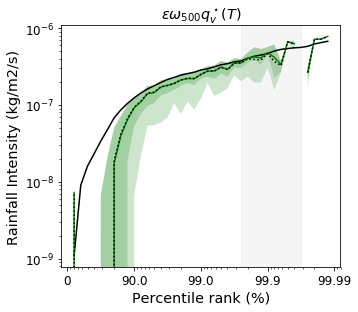

In [303]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks,i_Q_lims,alpha=0.15,transformX=False)
# 90% confidence interval for pointwise scaling 2
subplotYShadingRanksILog(ax,ranks,[pr_sc2_I90[:,0],pr_sc2_IQR[:,1]],col='green',transformX=False)
# Interquartile range for pointwise scaling 2
subplotYShadingRanksILog(ax,ranks,[pr_sc2_IQR[:,0],pr_sc2_IQR[:,1]],col='green',transformX=False)
# Mean of pointwise scaling 2
subplotRanksILog(ax,ranks,[centers,pr_sc2_prQ,pr_sc2_vQ],col=['k','green','k'],ltype=['-','-',':'],transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Rainfall Intensity (kg/m2/s)')
ax.set_title(r'$\varepsilon\omega_{500}q_v^\star(T)$')

plt.show()

## Decompose the bias

### into its contributions from qvstar and omega (scaling #3)

In [16]:
iQ_slice = slice(25,35)

In [304]:
qvstar_s_prQ = np.array(list(map(lambda x: meanXAtYPercentiles(x,qvstar_s,pr,rank_locations=rank_locations),ranks)))
omega_500_prQ = np.array(list(map(lambda x: meanXAtYPercentiles(x,omega_500,pr,rank_locations=rank_locations),ranks)))

In [305]:
print("Compute bias")
bias_sc_2 = (pr_sc2_prQ - pr_sc2_vQ)/pr_sc2_prQ
print(np.nanmean(bias_sc_2[iQ_slice]))

Compute bias
0.0382513120363


In [306]:
print("Compute covariance term")
cov_qvstar_s_omega_500_prQ = np.array(list(map(lambda x: covAtYPercentiles(x,qvstar_s,omega_500,pr,
                                                                           rank_locations=rank_locations),ranks)))

Compute covariance term


In [307]:
contrib_b2_cov_qvstar_s_omega_500 = cov_qvstar_s_omega_500_prQ*(-eps_2/gg)/pr_sc2_prQ

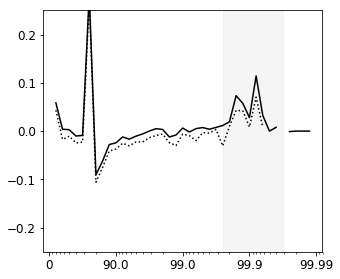

In [308]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.25,.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks,i_Q_lims,alpha=0.15,transformX=False)

subplotRanksILog(ax,ranks,
                 bias_sc_2,
                 col='k',ltype='-',transformX=False)
# subplotRanksILog(ax,ranks,
#                  [contrib_bias_varT,contrib_bias_covOmegaT,contrib_bias_sum],
#                  col=['r','b','k'],ltype=['-','-',':'],transformX=True)
subplotRanksILog(ax,ranks,
                 contrib_b2_cov_qvstar_s_omega_500,
                 col='k',ltype=':',transformX=True)

plt.show()

### into its contributions from T, p and omega (scaling #2)

In [309]:
ts_prQ = np.array(list(map(lambda x: meanXAtYPercentiles(x,ts,pr,rank_locations=rank_locations),ranks)))
ps_prQ = np.array(list(map(lambda x: meanXAtYPercentiles(x,ps,pr,rank_locations=rank_locations),ranks)))
qvstar_ts_prQ = saturationSpecificHumidity(ts_prQ,ps_prQ)
omega_500_prQ = np.array(list(map(lambda x: meanXAtYPercentiles(x,omega_500,pr,rank_locations=rank_locations),ranks)))


In [310]:
contrib_bias_covOmegaT = L_v/R_v*cov_ts_omega_500_prQ/(ts_prQ**2)/omega_500_prQ

print(np.nanmean(contrib_bias_covOmegaT[25:33]))


0.0355906025717


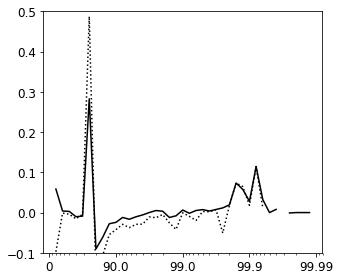

In [311]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.1,.5))

# subplotRanksILog(ax,Q_IL,np.zeros(Q_IL[1:-1].shape),ltype=':',col='k')
subplotRanksILog(ax,ranks,
                 bias_sc_2,
                 col='k',ltype='-',transformX=False)
subplotRanksILog(ax,ranks,
                 [contrib_bias_covOmegaT],
                 col=['k'],ltype=[':'],transformX=True)

plt.show()

## Decompose the variance

### into its contributions from qvstar and omega (scaling #3)

In [312]:
iQ_slice_small = slice(iQ_slice.start+2,iQ_slice.stop-2)

In [313]:
pr_sc2_prQ = np.array(list(map(lambda x: meanXAtYPercentiles(x,pr_sc2,pr,rank_locations=rank_locations),ranks)))
var_pr_sc2_prQ = np.array(list(map(lambda x: varXAtYPercentiles(x,pr_sc2,pr,rank_locations=rank_locations),ranks)))
var_pr_sc3_prQ = np.array(list(map(lambda x: varXAtYPercentiles(x,pr_sc3,pr,rank_locations=rank_locations),ranks)))

In [314]:
print("compute variability terms")
var_qvstar_s_prQ = np.array(list(map(lambda x: varXAtYPercentiles(x,qvstar_s,pr,rank_locations=rank_locations),
                                     ranks)))
var_omega_500_prQ = np.array(list(map(lambda x: varXAtYPercentiles(x,omega_500,pr,rank_locations=rank_locations),
                                      ranks)))
cov_qvstar_s_omega_500_prQ = np.array(list(map(lambda x: covAtYPercentiles(x,qvstar_s,omega_500,
                                                                           pr,rank_locations=rank_locations),
                                               ranks)))
cov_qvstar_s_2_omega_500_2_prQ = np.array(list(map(lambda x: covAtYPercentiles(x,qvstar_s**2,omega_500**2,pr,
                                                                               rank_locations=rank_locations),
                                                   ranks)))

compute variability terms


In [315]:
print("normalized variability")
norm_var_pr_sc3_prQ = var_pr_sc3_prQ/(pr_sc3_prQ**2)
print(np.nanmean(norm_var_pr_sc3_prQ[iQ_slice_small]))

normalized variability
0.141737481136


In [316]:
print("normalized contributions")
a_v_3 = (eps_3/gg)**2
contrib_covX2Y2 = a_v_3*cov_qvstar_s_2_omega_500_2_prQ/(pr_sc3_prQ**2)
contrib_var_agg = a_v_3*(var_qvstar_s_prQ+qvstar_s_prQ**2)*(var_omega_500_prQ+omega_500_prQ**2)/(pr_sc3_prQ**2)
contrib_covXY_agg = -a_v_3*(cov_qvstar_s_omega_500_prQ + qvstar_s_prQ*omega_500_prQ)**2/(pr_sc3_prQ**2)
contrib_sum_3_agg = contrib_covX2Y2+contrib_var+contrib_covXY
print(np.nanmean(contrib_covX2Y2[iQ_slice_small]),np.nanmean(contrib_var_agg[iQ_slice_small]),
      np.nanmean(contrib_covXY_agg[iQ_slice_small]),np.nanmean(contrib_sum_3_agg[iQ_slice_small]))

normalized contributions
0.115880302256 1.02585717888 -1.0 1.07670165965


In [318]:
N_prQ = np.array(list(map(lambda x: sampleSizeAtYPercentiles(x,pr,rank_locations=rank_locations),ranks)))

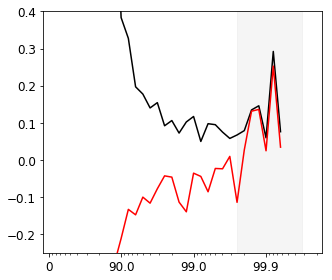

In [321]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.25,.4))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks,i_Q_lims,alpha=0.15,transformX=False)

subplotRanksILog(ax,ranks,
                 norm_var_pr_sc3_prQ,
                 col='k',ltype='-',transformX=False)
subplotRanksILog(ax,ranks,
                 [contrib_covX2Y2,contrib_var_agg,contrib_covXY_agg,contrib_sum_3_agg],
                 col=['r','b','g','pink'],ltype=['-','-','-','--'],transformX=True)

# ax2 = ax.twinx()
# ax2.set_yscale('log')
# subplotRanksILog(ax2,ranks,
#                  N_prQ,
#                  col='gray',ltype='-',transformX=True)
# ax2.tick_params(axis='y', colors='gray')

plt.show()

In [322]:
print("normalized contributions, expanded terms")
a_v_3 = (eps_3/gg)**2
contrib_covX2Y2 = a_v_3*cov_qvstar_s_2_omega_500_2_prQ/(pr_sc3_prQ**2)
contrib_varX = a_v_3*(omega_500_prQ**2)*var_qvstar_s_prQ/(pr_sc3_prQ**2)
contrib_varY = a_v_3*(qvstar_s_prQ**2)*var_omega_500_prQ/(pr_sc3_prQ**2)
contrib_varXvarY = a_v_3*var_qvstar_s_prQ*var_omega_500_prQ/(pr_sc3_prQ**2)
contrib_cov2XY = -a_v_3*(cov_qvstar_s_omega_500_prQ**2)/(pr_sc3_prQ**2)
contrib_covXY = -a_v_3*2*qvstar_s_prQ*omega_500_prQ*cov_qvstar_s_omega_500_prQ/(pr_sc3_prQ**2)
contrib_sum_3 = contrib_covX2Y2 + contrib_varX + contrib_varY + contrib_varXvarY + contrib_cov2XY + contrib_covXY

print(np.nanmean(contrib_varX[iQ_slice_small]),np.nanmean(contrib_varY[iQ_slice_small]),
      np.nanmean(contrib_varXvarY[iQ_slice_small]),
      np.nanmean(contrib_cov2XY[iQ_slice_small]),np.nanmean(contrib_covXY[iQ_slice_small]),
      np.nanmean(contrib_sum_3[iQ_slice_small]))

normalized contributions, expanded terms
0.0510806486479 0.0389902695021 0.00255836317487 -0.00173628095845 -0.0650358214866 0.141737481136


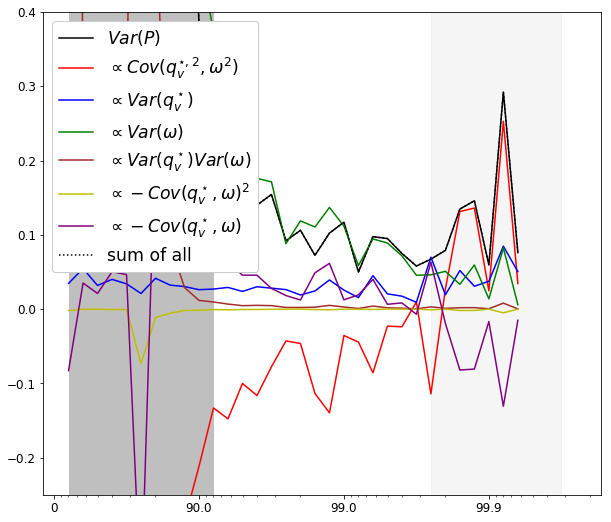

In [324]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(10,9))
ax.set_ylim((-.25,.4))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks,i_Q_lims,alpha=0.15,transformX=False)

subplotRanksILog(ax,ranks,
                 norm_var_pr_sc3_prQ,
                 col='k',ltype='-',transformX=False)
subplotRanksILog(ax,ranks,
                 [contrib_covX2Y2,contrib_varX,contrib_varY,contrib_varXvarY,contrib_cov2XY,contrib_covXY,contrib_sum_3],
                 col=['r','b','g','brown','y','purple','k'],ltype=['-','-','-','-','-','-',':'],transformX=False)

subplotXShadingRanksILog(ax,ranks,(0,10),alpha=1,col='white',transformX=True)

leg = ax.legend([r'$Var(P)$',
                 r'$\propto Cov(q_v^{\star,2},\omega^2)$',
                 r'$\propto Var(q_v^\star)$',
                 r'$\propto Var(\omega)$',
                 r'$\propto Var(q_v^\star)Var(\omega)$',
                 r'$\propto -Cov(q_v^\star,\omega)^2$',
                 r'$\propto -Cov(q_v^\star,\omega)$',
                 r'sum of all'],
                 loc='upper left',
                 fontsize='xx-large')
leg.get_frame().set_alpha(1)

# ax2 = ax.twinx()
# ax2.set_yscale('log')
# subplotRanksILog(ax2,ranks,
#                  N_prQ,
#                  col='gray',ltype='-',transformX=True)
# ax2.tick_params(axis='y', colors='gray')

plt.show()


### into its contributions from T, p and omega (scaling #2)

In [325]:
var_pr_sc2_prQ = np.array(list(map(lambda x: varXAtYPercentiles(x,pr_sc2,pr,rank_locations=rank_locations),ranks)))
var_pr_sc2_div_eps2_prQ = np.array(list(map(lambda x: varXAtYPercentiles(x,pr_sc2/eps_2,pr,
                                                                         rank_locations=rank_locations),ranks)))

In [332]:
var_ts_prQ = np.array(list(map(lambda x: varXAtYPercentiles(x,ts,pr,rank_locations=rank_locations),ranks)))
var_omega_500_prQ = np.array(list(map(lambda x: varXAtYPercentiles(x,omega_500,pr,rank_locations=rank_locations),
                                      ranks)))
cov_ts_omega_500_prQ = np.array(list(map(lambda x: covAtYPercentiles(x,ts,omega_500,pr,rank_locations=rank_locations),
                                         ranks)))
cov_ts_omega_500_2_prQ = np.array(list(map(lambda x: covAtYPercentiles(x,ts,omega_500**2,pr,rank_locations=rank_locations),
                                         ranks)))

In [327]:
var_ps_prQ = np.array(list(map(lambda x: varXAtYPercentiles(x,ps,pr,rank_locations=rank_locations),ranks)))
cov_ps_ts_prQ = np.array(list(map(lambda x: covAtYPercentiles(x,ps,ts,pr,rank_locations=rank_locations),ranks)))
cov_ps_omega_500_prQ = np.array(list(map(lambda x: covAtYPercentiles(x,ps,omega_500,pr,rank_locations=rank_locations),
                                         ranks)))

In [341]:
contrib_var_covTomega2 = 2*L_v/R_v*cov_ts_omega_500_2_prQ/(ts_prQ*omega_500_prQ)**2
contrib_var_covTomega = -2*L_v/R_v*cov_ts_omega_500_prQ/((ts_prQ**2)*omega_500_prQ)
contrib_var_varT = ((L_v/R_v)**2)*var_ts_prQ/(ts_prQ**4)
contrib_var_varomega = var_omega_500_prQ/(omega_500_prQ**2)
contrib_var_sum = contrib_var_covTomega2+contrib_var_covTomega+contrib_var_varT+contrib_var_varomega
all_contribs_var = [contrib_var_covTomega2,contrib_var_covTomega,contrib_var_varT,contrib_var_varomega,contrib_var_sum]
for contrib in all_contribs_var:
    print(np.nanmean(contrib[iQ_slice_small]),end=' ')

0.103799673256 -0.0564180171123 0.131213229463 0.0433216671421 0.22191655275 

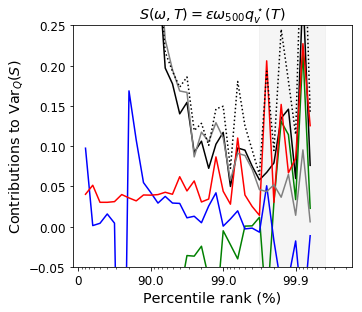

In [342]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_ylim((-0.05,0.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,Q_IL,i_Q_lims,alpha=0.15,transformX=False)


# subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
subplotRanksILog(ax,ranks,
                 norm_var_pr_sc2_prQ,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks,
                 all_contribs_var,
                 col=['green','blue','red','grey','k'],ltype=['-','-','-','-',':'],transformX=True)


# # Plot contributions
# ax2 = ax.twinx()
# ax2.set_ylim((-12,80))

# subplotRanksILog(ax2,ranks,
#                  var_terms[1:5],
#                  col=['green','blue','red','grey'],transformX=False)
# subplotRanksILog(ax2,ranks,
#                  var_terms_sum,
#                  col='k',ltype=':',transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to Var$_Q(S)$')
ax.set_title(r'$S(\omega,T)=\varepsilon\omega_{500}q_v^\star(T)$')

# ax2.legend([r'$\alpha_1 Var(T)$',r'$\alpha_2 Cov(T,\omega)$',r'$\alpha_3 Var(\omega)$','sum'])

plt.show()

In [328]:
a_var = (eps_2/gg*qvstar_ts_prQ)**2
# a_norm = 2*(qvstar_ts_prQ**2)
b_var = (omega_500_prQ*L_v/R_v/ts_prQ**2)
c1_var = a_var*b_var**2
c2_var = a_var*2*b_var
c3_var = a_var
c4_var = (eps_2/gg)**2/ps_prQ**2
c5_var = -2*(eps_2/gg)**2*L_v/R_v*omega_500_prQ*qvstar_ts_prQ/ts_prQ**2/ps_prQ
c6_var = -(eps_2/gg)**2*qvstar_ts_prQ/ps_prQ


In [330]:
contrib_varT = c1_var*var_ts_prQ/pr_sc2_vQ**2
contrib_covTomega = c2_var*cov_ts_omega_500_prQ/pr_sc2_vQ**2
contrib_varomega = c3_var*var_omega_500_prQ/pr_sc2_vQ**2
contrib_varP = c4_var*var_ps_prQ/pr_sc2_vQ**2
contrib_covPT = c5_var*cov_ps_ts_prQ/pr_sc2_vQ**2
contrib_covPomega = c6_var*cov_ps_omega_500_prQ/pr_sc2_vQ**2
contrib_bias = -contrib_bias_sum**2
sum_contribs = contrib_varT+contrib_covTomega+contrib_varomega+\
contrib_varP+contrib_covPT+contrib_covPomega+contrib_bias

# contrib_norm_varT = c1_norm*var_ts_prQ
# contrib_norm_covTomega = c2_norm*cov_ts_omega_500_prQ
# contrib_norm_varomega = c3_norm*var_omega_500_prQ
# sum_contribs = contrib_norm_varT+contrib_norm_covTomega+contrib_norm_varomega
# sum_contribs_norm = contrib_norm_varT+contrib_norm_varomega

print(np.nanmean(sum_contribs[iQ_slice_small]),np.nanmean(var_pr_sc2_prQ[iQ_slice_small]),
      np.nanmean(var_pr_sc2_div_eps2_prQ[iQ_slice_small]))
# print(sum_contribs_norm[25:33].mean(),var_pr_sc2_prQ[25:33].mean(),var_pr_sc2_div_eps2_prQ[25:33].mean())

278.055487014 2.43334616946e-14 8.70137442773e-08


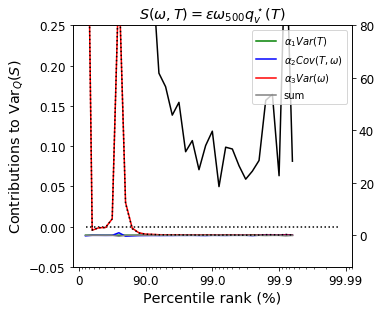

In [331]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_ylim((-0.05,0.25))

# # Grey shading 
# i_Q_lims = (i_Q-5,i_Q+4)
# subplotXShadingRanksILog(ax,Q_IL,i_Q_lims,alpha=0.15,transformX=False)

# normalizing_factor = (centers.copy())**2
# normalizing_factor[:5] = np.nan
var_terms = [var_pr_sc2_prQ/pr_sc2_vQ**2,contrib_varT,contrib_covTomega,contrib_varomega,contrib_bias]
# var_terms_normalized = [x/normalizing_factor for x in var_terms]
var_terms_sum = var_terms[1]+var_terms[2]+var_terms[3]+var_terms[4]

# var_terms_n_sum = var_terms_normalized[1]+var_terms_normalized[2]+var_terms_normalized[3]
# var_terms_n_sum = var_terms_normalized[1]+var_terms_normalized[3]
# var_terms_n_sum = var_terms_normalized[1]+2*var_terms_normalized[2]+var_terms_normalized[3]

subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
subplotRanksILog(ax,ranks,
                 var_terms[0],
                 col='k',ltype='-',transformX=False)

# Plot contributions
ax2 = ax.twinx()
ax2.set_ylim((-12,80))

subplotRanksILog(ax2,ranks,
                 var_terms[1:5],
                 col=['green','blue','red','grey'],transformX=False)
subplotRanksILog(ax2,ranks,
                 var_terms_sum,
                 col='k',ltype=':',transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to Var$_Q(S)$')
ax.set_title(r'$S(\omega,T)=\varepsilon\omega_{500}q_v^\star(T)$')

ax2.legend([r'$\alpha_1 Var(T)$',r'$\alpha_2 Cov(T,\omega)$',r'$\alpha_3 Var(\omega)$','sum'])

plt.show()

Why don't I get the same order of magnitude?
Check the order of magnitude of $\varepsilon_V$ for all variables, to see if I can actually do this Taylor expansion.

In [274]:
epsilon_T = np.sqrt(var_ts_prQ)/ts_prQ
epsilon_omega_500 = np.sqrt(var_omega_500_prQ)/omega_500_prQ
epsilon_ps = np.sqrt(var_ps_prQ)/ps_prQ
print(np.nanmean(epsilon_T[iQ_slice]),np.nanmean(epsilon_omega_500[iQ_slice]),np.nanmean(epsilon_ps[iQ_slice]))

0.0169689080102 -0.180611738943 0.0874370173534


## Maps of predictor variables

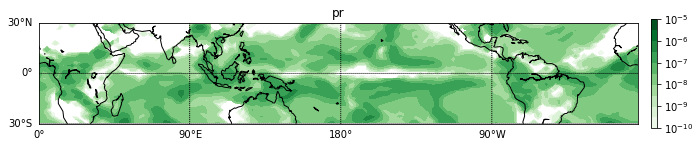

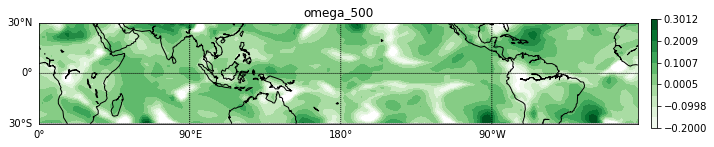

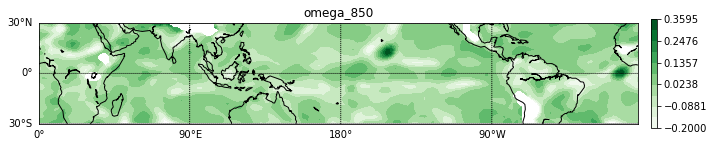

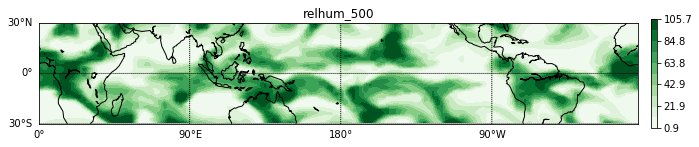

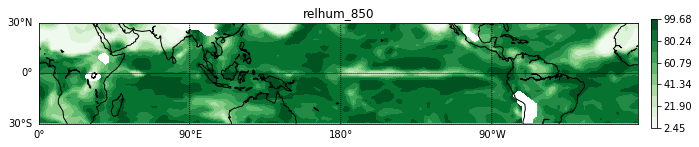

/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


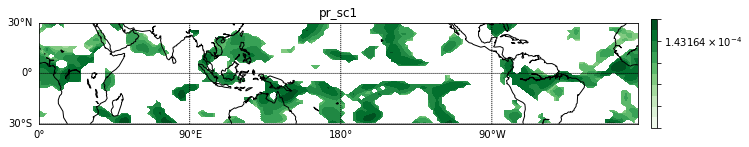

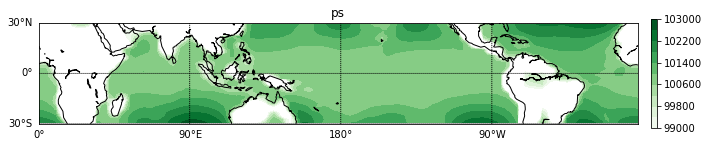

In [21]:
## Plot

vars2plot = ['pr','omega_500','omega_850','relhum_500','relhum_850','pr_sc1','ps']
v_lims ={'pr':[1e-10,1e-5],
         'omega_500':[-0.2,None],
         'omega_850':[-0.2,None],
         'relhum_500':[None,None],
         'relhum_850':[None,None],
         'pr_sc1':[None,None],
         'ps':[99000,103000]}
mode = {'pr':'log','omega_500':None,'omega_850':None,'relhum_500':None,'relhum_850':None,'pr_sc1':'log','ps':None}

for var in vars2plot:
    
    v = getattr(thismodule,var)[0,...]
    plotMapTropics(lon2D,lat2D,v,v_min=v_lims[var][0],v_max=v_lims[var][1],mode=mode[var],title=var)
    plt.show()